# Import Libraries

In [1]:
!pip install keras-tuner --upgrade --quiet

In [2]:
import numpy as np
import os
import pandas as pd
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras 
from tensorflow.keras import regularizers
from keras_tuner import HyperModel, RandomSearch

In [3]:
os.chdir("/content/drive/MyDrive/deep_learning/spaceship_titanic")
%ls

data/  kaggle.json  notebooks/  reports/  test.npz


# Load Dataset

In [14]:
data = np.load("data/train.npz", allow_pickle=True)
X = data["x"]
y = data["y"]
X = X.astype(float)
y = y.astype(float)
X.shape

(8693, 34)

# Split into train and validation

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Amount of Train Samples: {len(X_train)} - Amount of Validation Sample: {len(X_val)}")

Amount of Train Samples: 6519 - Amount of Validation Sample: 2174


# Standardize Dataset

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10) # divide to 10 PCs
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_components, columns=["PC_1", "PC_2", "PC_3",
                                                                "PC_4", "PC_5", "PC_6",
                                                                "PC_7", "PC_8", "PC_9",
                                                                "PC_10",])
principal_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,-0.337425,0.871520,0.142327,0.269201,0.475973,0.048914,-0.308314,-0.707293,-0.460580,-0.065413
1,0.196422,0.002373,-0.421760,-1.290702,-0.330429,0.066755,1.216187,-0.496475,0.460644,-0.074602
2,0.221750,0.231678,-0.545081,-1.563985,-0.366693,0.128924,-0.125923,-0.638168,0.662788,0.261115
3,-1.314897,-1.267963,0.403710,1.070926,0.289026,-0.169372,-0.393964,0.102290,0.186769,-0.077649
4,-0.017192,0.413452,0.297602,-1.029677,0.164224,0.245467,-0.458031,0.472297,0.080751,-0.162810


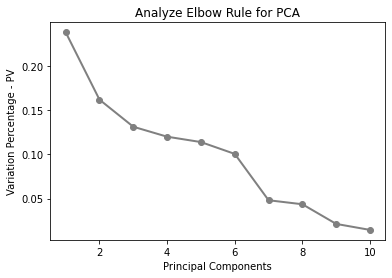

In [98]:
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, "bo-", linewidth=2, color="grey")
plt.title("Analyze Elbow Rule for PCA")
plt.xlabel("Principal Components")
plt.ylabel("Variation Percentage - PV")
plt.show()

In [100]:
sum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100, columns=["Cumulative_PV"])
print("Cumulative Variation Percentage (PV) Explained:")
print(sum)

Cumulative Variation Percentage (PV) Explained:
   Cumulative_PV
0      23.778697
1      39.945091
2      53.052731
3      65.036201
4      76.413312
5      86.453666
6      91.261003
7      95.616088
8      97.749771
9      99.207152


In [101]:
pca = PCA(n_components=10) # divide to 10 PCs
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [99]:
# scaler = MinMaxScaler()
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val) 
# X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], 1))
# X_val = np.reshape(X_val, newshape=(X_val.shape[0], X_val.shape[1], 1))

# Build FeedFoward Neural Network Model applying Tuner

In [49]:
class BuildHyperModel(HyperModel):
    def __init__(self, n_units_list, n_names_list, shape):
        self.n_units_list = n_units_list
        self.n_names_list = n_names_list
        self.shape = shape

    def build(self, hp):
        input = keras.Input(shape=self.shape)

        for i, (n_units, n_names) in enumerate(zip(self.n_units_list, self.n_names_list)):
            if (i == 0):
                x = keras.layers.Dense(hp.Int(f"units_{i+1}", n_units, n_units*2, default=n_units), 
                                        activation=hp.Choice(
                                            f"dense_activation_{i+1}",
                                            values=["relu", "elu"],
                                            default="relu"), 
                                        name=n_names,
                                        kernel_regularizer=regularizers.L2(
                                            hp.Choice(
                                                f"l2_{i+1}",
                                                values=[1e-3, 1e-4],
                                                default=1e-4
                                            )
                                            ))(input)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dropout(hp.Float(
                    f"dropout_{i+1}",
                    min_value=0.45,
                    max_value=0.5,
                    default=0.5,
                    step = 0.01
                ))(x)
            else:
                x = keras.layers.Dense(hp.Int(f"units_{i+1}", n_units, n_units*2, default=n_units), 
                                        activation=hp.Choice(
                                            f"dense_activation_{i+1}",
                                            values=["relu", "elu"],
                                            default="relu"), 
                                        name=n_names,
                                        kernel_regularizer=regularizers.L2(
                                            hp.Choice(
                                                f"l2_{i+1}",
                                                values=[1e-3, 1e-4],
                                                default=1e-4
                                            )
                                            ))(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dropout(hp.Float(
                    f"dropout_{i+1}",
                    min_value=0.45,
                    max_value=0.5,
                    default=0.5,
                    step = 0.01
                ))(x)

        n_units = int(self.n_units_list[-1]//2)
        x = keras.layers.Dense(
            hp.Int(
                "units_last_hidden",
                n_units, n_units*2, default=n_units
                ),
            activation=hp.Choice(
                "dense_activation_last_hidden",
                values=["relu", "elu"],
                default="relu"
            ),
            kernel_regularizer=regularizers.L2(
                hp.Choice(
                    "l2_last_hidden",
                    values=[1e-3, 1e-4],
                    default=1e-4
                )
            ),
            name="last_hidden")(x)
        output = keras.layers.Dense(1, activation="sigmoid", name="output")(x)
        model = keras.Model(inputs=input, outputs=output)
        
        lr = hp.Choice(
            "learning_rate",
            values=[1e-3, 1e-4]
        )
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        metrics = [
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(),
        ]
        model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=metrics)
        return model

In [50]:
n_units = [32, 32]
n_names = ["hidden_1", "hidden_2"]
shape = X_train.shape[1:]
hm = BuildHyperModel(n_units, n_names, shape)

In [51]:
rs_tuner = RandomSearch(
    hm,
    objective="val_accuracy",
    seed=42,
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="reports",
    project_name="random_search"
)

In [52]:
rs_tuner.search_space_summary()

Search space summary
Default search space size: 12
units_1 (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': None}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
l2_1 (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
dropout_1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.45, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
units_2 (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': None}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
l2_2 (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
dropout_2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.45, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
units_last_hidden (Int)
{'default': 16, 'conditions': [], 'min_value'

# Run Random Search tuner

In [53]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=8),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, mode="max",
                                      )
]

In [54]:
rs_tuner.search(X_train, y_train, epochs=50,
                validation_data=(X_val, y_val), verbose=1, callbacks=callbacks,
                batch_size=64)

Trial 10 Complete [00h 00m 31s]
val_accuracy: 0.7798221309979757

Best val_accuracy So Far: 0.7865685423215231
Total elapsed time: 00h 10m 06s


In [55]:
best_model = rs_tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 hidden_1 (Dense)            (None, 52)                1820      
                                                                 
 batch_normalization (BatchN  (None, 52)               208       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 52)                0         
                                                                 
 hidden_2 (Dense)            (None, 60)                3180      
                                                                 
 batch_normalization_1 (Batc  (None, 60)               240       
 hNormalization)                                             

In [56]:
loss, accuracy, auc = best_model.evaluate(X_train, y_train)

204/204 [==============================] - 1s 3ms/step - loss: 0.4204 - accuracy: 0.8106 - auc: 0.8931


In [57]:
loss, accuracy, auc = best_model.evaluate(X_val, y_val)

68/68 [==============================] - 0s 3ms/step - loss: 0.4442 - accuracy: 0.7879 - auc: 0.8757


# Save Best Model

In [58]:
best_model.save("reports/final_model.h5")

# Predict Submission Dataset

In [59]:
X_test = np.load("data/test.npz", allow_pickle=True)["x"]
X_test = X_test.astype(float)
X_test.shape

(4277, 34)

In [60]:
y_pred = best_model.predict(X_test,)

134/134 [==============================] - 0s 2ms/step


In [61]:
print(y_pred[:])

[[0.5964853 ]
 [0.03084361]
 [0.9836316 ]
 ...
 [0.9426545 ]
 [0.8852611 ]
 [0.7083568 ]]


In [62]:
df = pd.read_csv("data/sample_submission.csv")
df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [63]:
def get_prediction(test_data):
    y_pred = best_model.predict(test_data)
    y_pred = [True if y > 0.5 else False for y in y_pred]
    df["Transported"] = y_pred

In [64]:
get_prediction(X_test)

134/134 [==============================] - 0s 2ms/step


In [65]:
np.unique(df["Transported"])

array([False,  True])

In [66]:
df.to_csv("reports/output.csv", index=False)